In [2]:
import keras
import numpy as np
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

/home/ngundotra/.conda/envs/torchenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
data = []
max_w, max_h = 0, 0
for img_path in glob.glob("pokepics/*.png"):
    name = img_path[:-4]
    name = name[len('pokepics') + 1:]
    try:
        img = imageio.imread(img_path)
    except ValueError:
        print(img_path, "could not load")
    data.append((name, img))
    if img.shape[0] > max_w:
        max_w = img.shape[0]
    if img.shape[1] > max_h:
        max_h = img.shape[1]
#     print(name, img.shape)

print(len(data))

pokepics/Type: Null.png could not load
pokepics/Silvally.png could not load
pokepics/Minior.png could not load
pokepics/Togedemaru.png could not load
807


Text(0.5,1,'Spritzee')

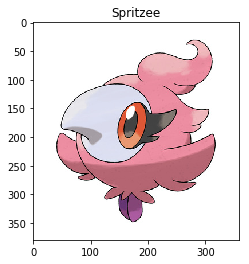

In [4]:
def pad_data(img, max_w, max_h, white=255):
    """Zero pads an image to max_w and max_h with `white` values.
    Tries to keep the img in the center of the padding."""
    offset = 0.1 # Found by testing :P
    pad = (max_w - img.shape[0], max_h - img.shape[1])
    # Breaks ties by taking lesser amount on left side of pad
    pad_width = [(p // 2, round(p / 2 + offset)) for p in pad] + [(0, 0)]
    new_img = np.pad(img, pad_width=tuple(pad_width), mode='constant', constant_values=white)
    
    # For debugging
    if new_img.shape != (max_w, max_h, 3):
        print(img.shape)
    return new_img

# Testing
idx = np.random.choice(range(len(data)))
test_img = pad_data(data[idx][1], max_w, max_h)
plt.imshow(test_img)
plt.title(data[idx][0])

## Pad All Pokemon Images

In [26]:
padded_data = []
mean = 0
for pair in data:
    biggest = max(max_w, max_h)
    new_pair = (pair[0], pad_data(pair[1], biggest, biggest))
    assert new_pair[1].shape == (biggest, biggest, 3), "Padding failed {}".format(new_pair[1].shape)
    padded_data.append(new_pair)

val = 0.2
train_idx = len(padded_data) * 0.2
train_idx = round(train_idx)
train_data = padded_data[:train_idx]
val_data = padded_data[train_idx:]
mean = 0
for img in (pair[1] for pair in train_data):
    mean += img.reshape(-1).mean()
mean /= train_idx
std = 0
for img in (pair[1] for pair in train_data):
    std += (img - mean).reshape(-1).mean()
std /= train_idx

normal_data = [] 
for pair in padded_data:
    img = (pair[1] - mean)/std
    normal_data.append((pair[0], img))

In [7]:
len(padded_data)

807

## Tokenize Pokemon Names

Finding all characters

In [8]:
tokens = set()
for name in (x[0] for x in data):
    name = name.lower()
    for char in name:
        tokens.add(char)
print(len(tokens), "tokens found")

35 tokens found


Creating appropriate translation structures

In [9]:
all_tok = sorted(tokens)
print(all_tok)

idx2char = all_tok
char2idx = {a:i for i, a in enumerate(all_tok)}

[' ', "'", '-', '.', '2', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é', '♀', '♂']


Tokenizing names

In [10]:
num_tok = len(all_tok)

# Now data is prepared for deep learning
deep_data = []
for pair in padded_data:
    name, img = pair
    name = name.lower()
    new_name = np.zeros((len(name), num_tok))
    for i, char in enumerate(name):
        new_name[i, char2idx[char]] = 1
    assert np.sum(np.sum(new_name)) == len(name)
    deep_data.append((new_name, img))

In [11]:
len(deep_data)

807

## Deep Learning Reacts?

In [12]:
from keras.layers import Input, Dense, Dropout, Conv2D, UpSampling2D, Flatten, Reshape, \
    MaxPool2D, BatchNormalization, Cropping2D
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.backend import clear_session

## Autoencoding the Pictures

In [35]:
clear_session()

x_in = Input(shape=(biggest, biggest, 3))
x = Conv2D(64, (5, 5), padding='valid', activation='relu')(x_in)
x = Conv2D(64, (5, 5), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 190 x 190 x 256
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 95 x 95 x 256
x = Conv2D(128, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 40 x 40 x 256
x = Conv2D(256, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D()(x) # 20 x 20 x 256

encoder = Model(x_in, x)

# Decoder goes from (20, 20, 16) to (380, 380, 3)
def upsample_block(filters, kernels, x):
    x = Conv2D(filters[0], kernels[0], padding='same', activation='relu')(x)
    x = Conv2D(filters[1], kernels[1], padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    return x

d_in = Input(shape=(20, 20, 64))
x = upsample_block((256, 64), ((5,5), (5,5)), d_in) # 40
x = upsample_block((64, 64), ((5,5), (5,5)), x) # 80
x = UpSampling2D()(x)
x = upsample_block((64, 16), ((3,3), (3,3)), x) # 320
x = UpSampling2D()(x) # 640
# Want 380 x 380
buff = (640 - biggest) // 2
x = Cropping2D(cropping=buff)(x)
x = Conv2D(8, (3,3), padding='same', activation='relu')(x)
x = Conv2D(3, (3,3), padding='same', activation='sigmoid')(x)
decoder = Model(d_in, x)

autoencoder = Model(x_in, decoder(encoder.output))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [36]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 256)       409856    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        409664    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 40, 40, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 64)        102464    
__________

In [27]:
pics = [data[1] for data in normal_data]
pics = np.array(pics)
print(pics.shape)

(807, 380, 380, 3)


In [37]:
def plot(pics):
    idx = np.random.choice(len(pics), size=4)
    imgs = pics[idx]
    ys = autoencoder.predict(imgs)
    fig, axes = plt.subplots(nrows=2, ncols=4)
    for i in range(4):
        top = axes[0, i]
        bot = axes[1, i]
        y = ys[i]
        img = imgs[i]
        top.imshow(y)
        bot.imshow(img*std + mean)
        for ax in (top, bot):
            ax.set_xticks([])
            ax.set_yticks([])
    fig.savefig("plotsave.png", figsize=(8, 4), dpi=150)
    plt.close(fig)

callback = keras.callbacks.LambdaCallback(on_epoch_begin=lambda batch, logs: plot(pics[:12]))


Epoch 1/200
12/12 [==============================] - 2s 145ms/step - loss: 84496904880128.0000
Epoch 2/200
12/12 [==============================] - 1s 61ms/step - loss: 123469874331648.0000
Epoch 3/200
12/12 [==============================] - 1s 58ms/step - loss: -335499122180096.0000
Epoch 4/200
12/12 [==============================] - 1s 59ms/step - loss: 360782856192.0000
Epoch 5/200
12/12 [==============================] - 1s 61ms/step - loss: -1616382621908992.0000
Epoch 6/200
12/12 [==============================] - 1s 60ms/step - loss: -2402996621148160.0000
Epoch 7/200
12/12 [==============================] - 1s 59ms/step - loss: -3812531604815872.0000
Epoch 8/200
12/12 [==============================] - 1s 62ms/step - loss: -4814435000516608.0000
Epoch 9/200
12/12 [==============================] - 1s 60ms/step - loss: -6063753476964352.0000
Epoch 10/200
12/12 [==============================] - 1s 59ms/step - loss: -7450348234997760.0000
Epoch 11/200
12/12 [===================

KeyboardInterrupt: 

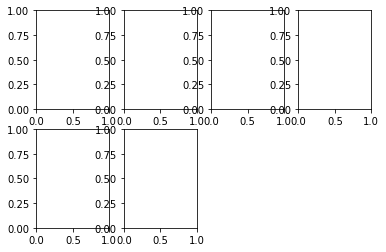

In [38]:
autoencoder.fit(pics[:12], pics[:12], callbacks=[callback], batch_size=12, epochs=200)